Loaded dataset with shape: (5000, 10)
Automatically selected features: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Humidity', 'Temperature']
Creating Category using PM2.5 thresholds on column: PM2.5
Using label column: Category
Category
0    3956
1     713
2     215
3      68
4      48
Name: count, dtype: int64
Feature columns used: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Humidity', 'Temperature']
Target distribution:
 Category
0    3956
1     713
2     215
3      68
4      48
Name: count, dtype: int64
Train shape: (4000, 7) Test shape: (1000, 7)
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV accuracy: 0.96275
Test Accuracy: 0.966
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       791
           1       0.91      0.87      0.89       143
           2       0.88      0.88      0.88        43
           3       0.92  

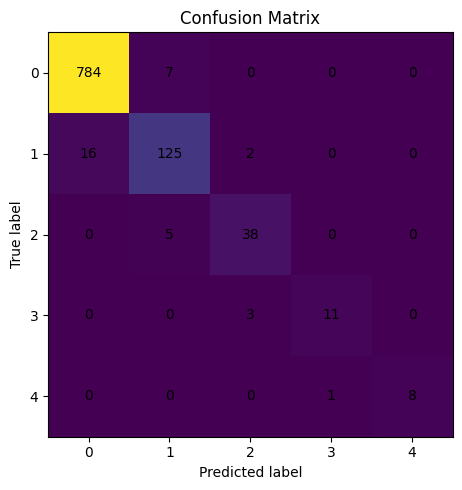

Saved trained model to knn_pollution_model.joblib

Example prediction (median values):
{'PM2.5': 12.0, 'PM10': 21.7, 'NO2': 25.3, 'SO2': 8.0, 'CO': 1.41, 'Humidity': 69.8, 'Temperature': 29.0}
{'predicted_category': 0, 'meaning': 'Good'}

Example prediction (high pollution sample - 95th percentile):
{'PM2.5': np.float64(68.4), 'PM10': np.float64(84.70500000000003), 'NO2': np.float64(43.1), 'SO2': np.float64(23.6), 'CO': np.float64(2.53), 'Humidity': np.float64(97.90500000000003), 'Temperature': np.float64(42.6)}
{'predicted_category': 2, 'meaning': 'Poor'}


In [8]:
#!/usr/bin/env python3
"""
knn_pollution.py
Pollution level categorization using K-Nearest Neighbours (KNN).

Copy this file and run:
    python knn_pollution.py

It expects the dataset at /mnt/data/updated_pollution_dataset.csv.
Adjust DATA_PATH if your CSV is elsewhere.
"""

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib

DATA_PATH = "updated_pollution_dataset.csv"
MODEL_PATH = "knn_pollution_model.joblib"

def load_dataset(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}. Please provide a CSV.")
    df = pd.read_csv(path)
    print("Loaded dataset with shape:", df.shape)
    return df

def auto_select_features(df):
    # Candidate keys (various naming variants)
    candidate_features = [
        "PM2.5", "PM2_5", "PM25", "PM10", "NO2", "NO_2", "SO2", "SO_2",
        "CO", "O3", "O_3", "AQI", "Humidity", "Temperature", "RH", "Temp"
    ]
    lower_map = {c.lower(): c for c in df.columns}
    chosen_features = []
    for cand in candidate_features:
        key = cand.lower()
        if key in lower_map:
            chosen_features.append(lower_map[key])
    if len(chosen_features) == 0:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        exclude = [c for c in numeric_cols if 'id' in c.lower() or 'time' in c.lower() or 'date' in c.lower()]
        chosen_features = [c for c in numeric_cols if c not in exclude]
    return chosen_features

def prepare_label(df):
    # Try to find an existing label column
    possible_label_names = ["Category", "category", "Label", "label", "PollutionLevel", "pollution_level", "AQI_Category"]
    for name in possible_label_names:
        if name in df.columns:
            print("Found label column:", name)
            return df, name

    # If AQI exists, convert AQI -> Category
    aqi_candidates = [c for c in df.columns if c.lower() == "aqi"]
    if len(aqi_candidates) > 0:
        aqi_col = aqi_candidates[0]
        print("Using AQI column to create categories:", aqi_col)
        def aqi_to_cat(a):
            if pd.isna(a):
                return np.nan
            a = float(a)
            if a <= 50:
                return 0
            elif a <= 100:
                return 1
            elif a <= 150:
                return 2
            elif a <= 200:
                return 3
            else:
                return 4
        df["Category"] = df[aqi_col].apply(aqi_to_cat)
        return df, "Category"

    # Else fallback to PM2.5 thresholding
    pm25_candidates = [c for c in df.columns if c.lower() in ("pm2.5", "pm2_5", "pm25", "pm2.5 (µg/m3)")]
    if len(pm25_candidates) > 0:
        pm25 = pm25_candidates[0]
        print("Creating Category using PM2.5 thresholds on column:", pm25)
        def pm25_to_cat(v):
            if pd.isna(v):
                return np.nan
            v = float(v)
            if v <= 30:
                return 0
            elif v <= 60:
                return 1
            elif v <= 90:
                return 2
            elif v <= 120:
                return 3
            else:
                return 4
        df["Category"] = df[pm25].apply(pm25_to_cat)
        return df, "Category"

    raise ValueError("Could not determine or create a label column. Ensure CSV has 'Category' or 'AQI' or PM2.5.")

def build_and_train(X_train, y_train):
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ])

    param_grid = {
        "knn__n_neighbors": list(range(1, 16, 2)),
        "knn__weights": ["uniform", "distance"],
        "knn__p": [1, 2]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best CV accuracy:", grid.best_score_)
    return grid.best_estimator_, grid

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", acc)
    print("Classification report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6,5))
    ax.imshow(cm, interpolation='nearest')
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return acc, cm

def main():
    df = load_dataset(DATA_PATH)
    chosen_features = auto_select_features(df)
    print("Automatically selected features:", chosen_features)
    if len(chosen_features) < 2:
        raise ValueError("Too few numeric features detected.")

    df, label_col = prepare_label(df)
    print("Using label column:", label_col)
    print(df[label_col].value_counts(dropna=False))

    df = df.dropna(subset=[label_col]).reset_index(drop=True)

    # Ensure we don't leak label features into X
    features = [f for f in chosen_features if f != label_col]
    X = df[features].copy()
    y = df[label_col].astype(int).copy()

    print("Feature columns used:", features)
    print("Target distribution:\n", y.value_counts())

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # Train
    best_model, grid = build_and_train(X_train, y_train)

    # Evaluate
    evaluate(best_model, X_test, y_test)

    # Save model
    joblib.dump(best_model, MODEL_PATH)
    print(f"Saved trained model to {MODEL_PATH}")

    # Example predictions
    median_vals = X.median().to_dict()
    high_vals = {k: (X[k].quantile(0.95) if np.isfinite(X[k].quantile(0.95)) else X[k].max()) for k in X.columns}

    def predict_pollution(sample_dict):
        sample = pd.DataFrame([sample_dict], columns=features)
        pred = best_model.predict(sample)[0]
        meaning = {0: "Good", 1: "Moderate", 2: "Poor", 3: "Very Poor", 4: "Severe"}.get(pred, str(pred))
        return {"predicted_category": int(pred), "meaning": meaning}

    print("\nExample prediction (median values):")
    print(median_vals)
    print(predict_pollution(median_vals))

    print("\nExample prediction (high pollution sample - 95th percentile):")
    print(high_vals)
    print(predict_pollution(high_vals))

if __name__ == "__main__":
    main()
